In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Dataset: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


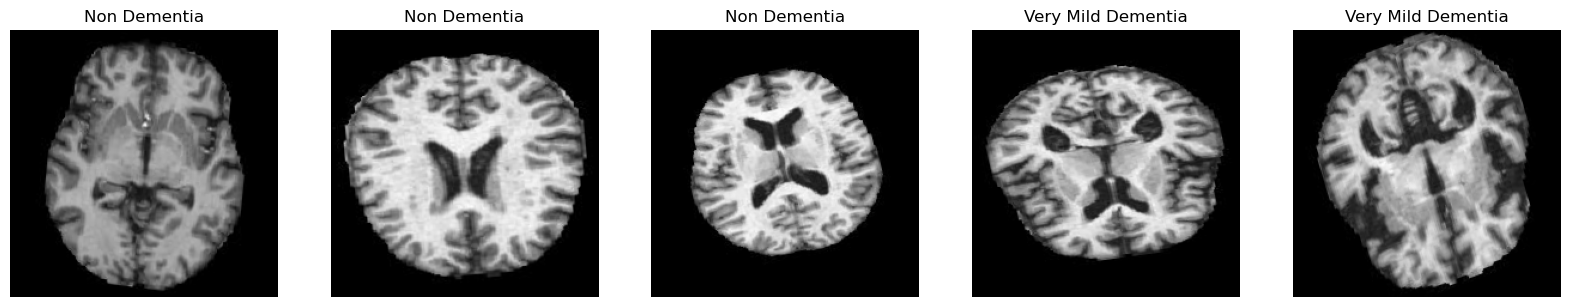

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

for i in range(5):
    rand1 = np.random.randint(len(train_dataset))
    max_index = min(len(train_dataset[rand1][0]), 100)  # Get the maximum index for this sample
    rand2 = np.random.randint(max_index)
    
    ax[i].axis('off')
    
    if rand2 < len(train_dataset[rand1][0]):  # Check if rand2 is within bounds
        ax[i].imshow(train_dataset[rand1][0][rand2])
        a = train_dataset[rand1][1][rand2]
        
        if a[0] == 1:
            ax[i].set_title('Mild Dementia')
        elif a[1] == 1:
            ax[i].set_title('Moderate Dementia')
        elif a[2] == 1:
            ax[i].set_title('Non Dementia')
        elif a[3] == 1:
            ax[i].set_title('Very Mild Dementia')
    else:
        ax[i].text(0.5, 0.5, 'Index out of bounds', ha='center', va='center')


In [35]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [36]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [37]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 1664)        0         
                                                                 
 flatten_2 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_6 (Bat  (None, 81536)             326144    
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 2048)              166987776 
                                                                 
 batch_normalization_7 (Bat  (None, 2048)              8192      
 chNormalization)                                     

In [39]:
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [40]:
# Defining Callbacks

filepath = './best_weights.h5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [41]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)


Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.3062 - auc: 0.7971 
Epoch 1: val_auc improved from -inf to 0.67912, saving model to .\best_weights.h5
33/33 [==============================] - 1030s 30s/step - loss: 1.3062 - auc: 0.7971 - val_loss: 3.4502 - val_auc: 0.6791
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.0390 - auc: 0.8440 
Epoch 2: val_auc improved from 0.67912 to 0.75654, saving model to .\best_weights.h5
33/33 [==============================] - 952s 29s/step - loss: 1.0390 - auc: 0.8440 - val_loss: 2.5523 - val_auc: 0.7565
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.9979 - auc: 0.8497 
Epoch 3: val_auc did not improve from 0.75654
33/33 [==============================] - 977s 30s/step - loss: 0.9979 - auc: 0.8497 - val_loss: 1.9367 - val_auc: 0.7250
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.9193 - auc: 0.8640 
Epoch 4: val_auc did not improve from 0.75654
33/33 [======

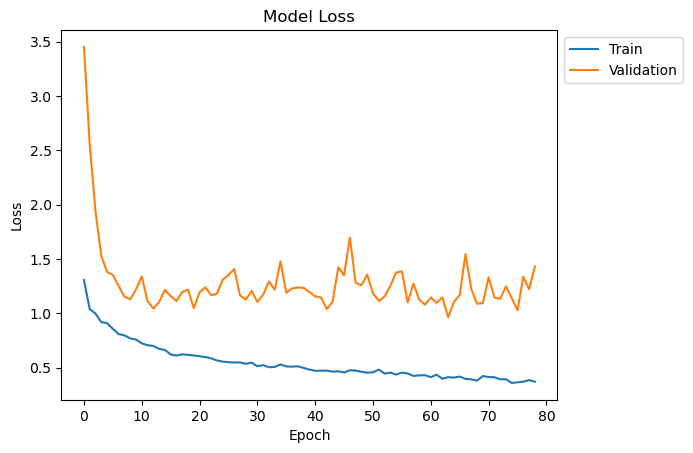

In [42]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

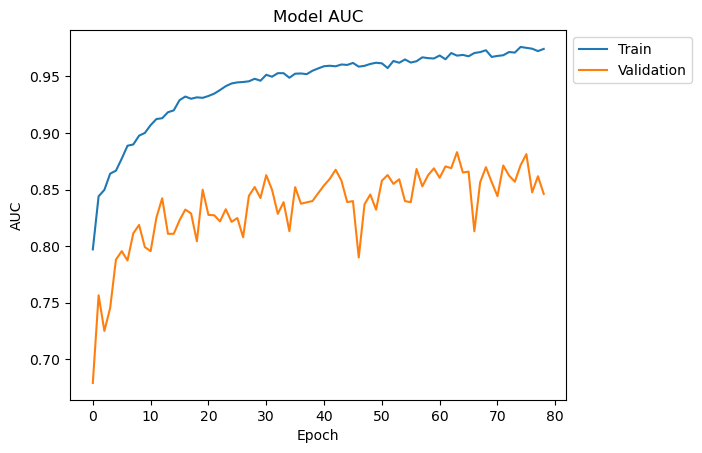

In [43]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [8]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [45]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 37s 4s/step - loss: 1.3838 - auc: 0.8655


[1.383763074874878, 0.8655314445495605]

1/1 [==============================] - 2s 2s/step
99.99 % chances are there that the image is NonDemented


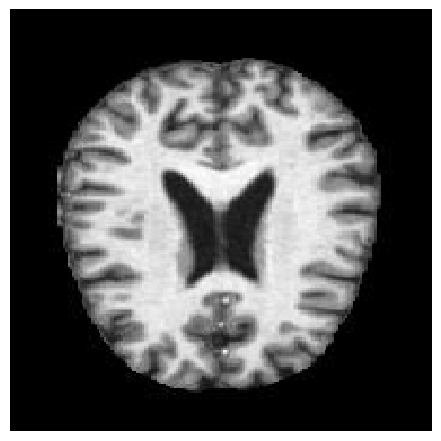

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imshow
import numpy as np

# Assuming 'model1' is your loaded model
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize the image

imshow(img_array)
plt.axis('off')

# Expand the dimensions to match the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the class label using the index
predicted_class_label = idc[predicted_class_index]

# Probability of prediction (if needed)
probability = round(np.max(prediction) * 100, 2)

print(probability, '% chances are there that the image is', predicted_class_label)


1/1 [==============================] - 0s 120ms/step
99.41 % chances are there that the image is MildDemented


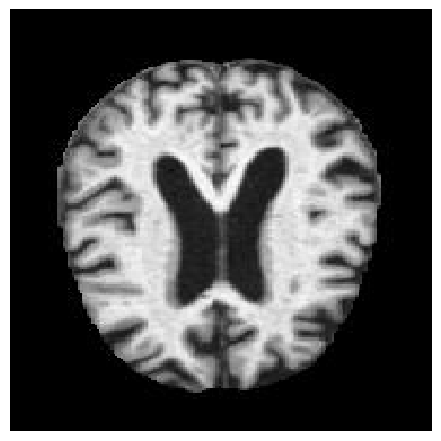

In [49]:
# Assuming 'model1' is your loaded model
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize the image

imshow(img_array)
plt.axis('off')

# Expand the dimensions to match the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the class label using the index
predicted_class_label = idc[predicted_class_index]

# Probability of prediction (if needed)
probability = round(np.max(prediction) * 100, 2)

print(probability, '% chances are there that the image is', predicted_class_label)


1/1 [==============================] - 0s 118ms/step
99.38 % chances are there that the image is ModerateDemented


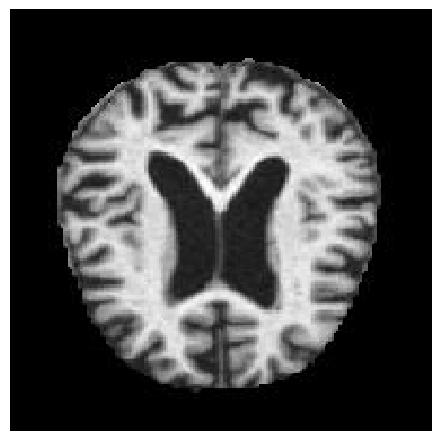

In [50]:
# Assuming 'model1' is your loaded model
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize the image

imshow(img_array)
plt.axis('off')

# Expand the dimensions to match the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the class label using the index
predicted_class_label = idc[predicted_class_index]

# Probability of prediction (if needed)
probability = round(np.max(prediction) * 100, 2)

print(probability, '% chances are there that the image is', predicted_class_label)


1/1 [==============================] - 0s 99ms/step
48.7 % chances are there that the image is VeryMildDemented


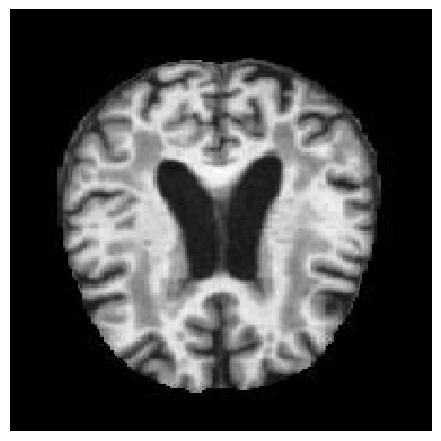

In [51]:
# Assuming 'model1' is your loaded model
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize the image

imshow(img_array)
plt.axis('off')

# Expand the dimensions to match the model's input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the class label using the index
predicted_class_label = idc[predicted_class_index]

# Probability of prediction (if needed)
probability = round(np.max(prediction) * 100, 2)

print(probability, '% chances are there that the image is', predicted_class_label)


In [52]:
# Saving a TensorFlow model
model.save('my_model.h5') 

In [2]:
from keras.models import load_model
from keras.utils import to_categorical
import numpy as np

# Load the saved model
model = load_model('C:/Users/Prajwal/Desktop/Mini Project/my_model.h5')


In [9]:
y_pred=model.predict(test_dataset)

10/10 [==============================] - 54s 5s/step


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_directory(directory='C:/Users/Prajwal/Desktop/Mini Project/Alzheimer_s Dataset/test',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=False)

# Gather predictions and true labels for the test set
predictions = []
true_labels = []

for i in range(len(test_dataset)):
    images, labels = test_dataset[i]
    pred = model.predict(images)
    predictions.extend(np.argmax(pred, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))


Found 1279 images belonging to 4 classes.
4/4 [==============================] - 9s 1s/step


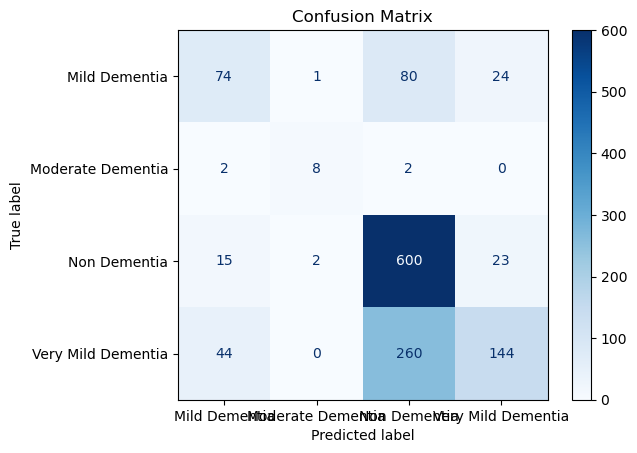

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
labels = ['Mild Dementia', 'Moderate Dementia', 'Non Dementia', 'Very Mild Dementia']
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
